____

![image info](https://www.iff.com/sites/iff-corp/files/styles/desktop/public/iff/home/iff-logo.png?itok=THWMQJ_v)
____



#### IFF Data Science Case Study                                                                                                       
#### Author: Randy Bukasa

This analysis will attempt to understand the relationship between crude oil price and ingredient prices over a period of time.

Motivation:

Identifying the extent of the relationship will allow IFF to make recommendations in order to fulfull business objectives such as improved financial planning, accurate procurement strategies and efficient product pricing.

### Content

* [1 Data loading and overview](#data_loading)
* [2 Exploratory Data Analysis](#exploratory_data_analysis)
* [3 Correlation_Analysis](#Correlation_Analysis)
* [4 Modeling](#model_development)
* [5 Recommendation](#Recommendation)

In [2]:
#Import relative libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import seaborn as sns
from datetime import datetime
plt.rcParams['figure.figsize'] = (15,3)
import warnings
warnings.filterwarnings('ignore')

<a id='data_loading'></a>
#### Data loading and overview

In [3]:
ingredients = pd.read_csv(r'ingredient_prices.csv',  thousands=',')
oils = pd.read_csv(r'oil_prices.csv', thousands=',')
#appears to be montly measures
print(ingredients.head().sort_values(by='Price', ascending=True))
#daily
print(oils.head())

       Date  Price
0  1/1/2005  570.0
1  2/1/2005  570.0
4  5/1/2005  570.0
3  4/1/2005  600.0
2  3/1/2005  610.0
        Date  Price
0  5/20/1987  18.63
1  5/21/1987  18.45
2  5/22/1987  18.55
3  5/25/1987  18.60
4  5/26/1987  18.63


In [4]:
#Make dates the index for easier processing of time series data
oils.Date = pd.to_datetime(oils.Date)
oils.set_index('Date', inplace=True)

ingredients.Date = pd.to_datetime(ingredients.Date)
ingredients.set_index('Date', inplace=True)

#resample oil data to monthly to match ingredients time series scale
oils = oils.resample('MS').mean()

<a id='exploratory_data_analysis'></a>
#### Exploratory Data Analysis

The goals are:
1. Find outliers if any and address them 
2. Find any missing values and treat them according

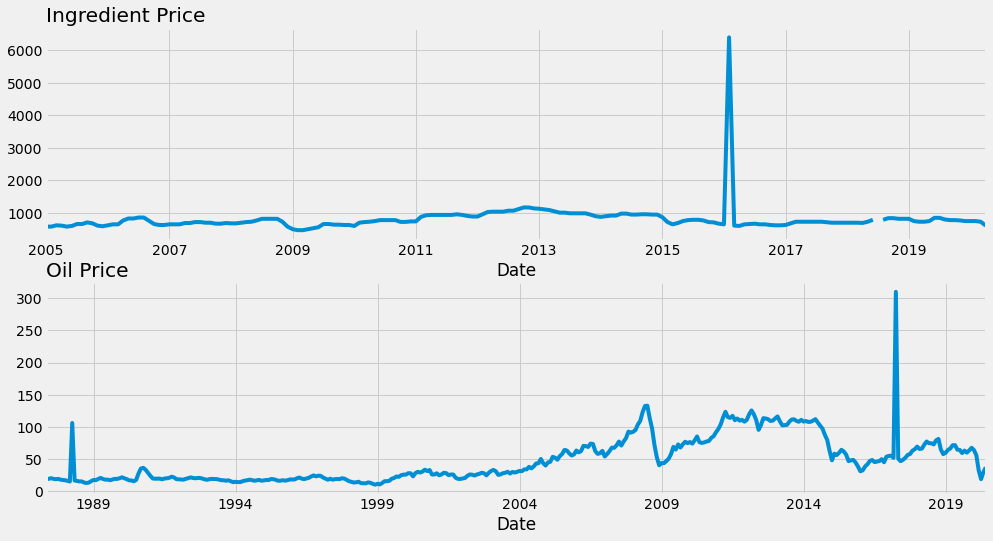

In [5]:
#Time series visualization of both prices
fig, ax = plt.subplots(figsize = (15, 8))
plt.subplot(2, 1, 1)
ingredients['Price'].plot();
plt.title('Ingredient Price', loc='left');
plt.subplot(2, 1, 2)
oils['Price'].plot();
plt.title('Oil Price', loc='left');

**Outliers:**
As displayed above, there are definitely outliers to look out for. These may be unintentional errors, but extreme. We will soften them by identifying them then smoothing them interpolate/linear values.

**Missing**
We will take a similar approach to fill in missing values to not lose any vital information.

In [6]:
#Make extreme outliers null then we can interpolate/smoothen
oils['Price'] = np.where(oils['Price'] < oils['Price'].quantile(0.00001), np.nan,
         (np.where(oils['Price'] > oils['Price'].quantile(0.999), np.nan, oils['Price'] )))


ingredients['Price'] = np.where(ingredients['Price'] < ingredients['Price'].quantile(0.00001), np.nan,
         (np.where(ingredients['Price'] > ingredients['Price'].quantile(0.999), np.nan, ingredients['Price'] )))

In [7]:
# Oil missing data summary
oil_unique_months = len(oils.index)
oil_min_date = oils.index.min().date()
oil_max_date = oils.index.max().date()
oil_delta = (oil_max_date - oil_min_date).days // 30
oil_missing_months = ((oil_delta - oil_unique_months) / oil_delta) *100

# Ingredients missing data summary
ingredients_unique_months = len(ingredients.index)
ingredients_min_date = ingredients.index.min()
ingredients_max_date = ingredients.index.max()
ingredients_delta = (ingredients_max_date - ingredients_min_date).days //30
ingredients_missing_months = ((ingredients_delta - ingredients_unique_months) / ingredients_delta) *100

print('OIL: First month:', oil_min_date, 'Last month:',oil_max_date, 'Total months:', oil_delta, 'Actual months:', oil_unique_months, 'Missing months:', round(oil_missing_months,2),'%')
print('INGREDIENTS: First month:', ingredients_min_date, 'Last month:',ingredients_max_date, 'Total months:', ingredients_delta, 'Actual months:', ingredients_unique_months,'Missing motnhs:', round(ingredients_missing_months,2),'%')

OIL: First month: 1987-05-01 Last month: 2020-06-01 Total months: 402 Actual months: 398 Missing months: 1.0 %
INGREDIENTS: First month: 2005-01-01 00:00:00 Last month: 2020-04-01 00:00:00 Total months: 185 Actual months: 184 Missing motnhs: 0.54 %


Not much missing data - we can will use entrapolate from pandas function with a default linear as models do not perfrom well with missing data in time series.

First lets analyze each series individually for insights.

In [8]:
#interpolate
ingredients = ingredients.interpolate()
oils = oils.interpolate()

# shorten the oils time series to the same period as ingreients
oils = oils[ingredients_min_date:ingredients_max_date]

# join both times series for analysis
df = ingredients.merge(oils, on='Date', how='inner').rename(columns={'Price_x': 'Price_ingredients',
                                                               'Price_y': 'Price_oil'})

<a id='Correlation_Analysis'></a>
**Stationarity**

Staionarity can be defined as the statistical properties of a process generating a time series do not change over time. With the data being stationary, one is able to make more accurate estimates about the data as there is less variability.

Properties of stationary data:

1) It should have a constant mean

2) It should have a constant variance

3) Auto covariance does not depend on the time

*Mean – it is the average value of all the data

*Variance – it is a difference of each point value from the mean

*Auto covariance –it is a relationship between any two values at a certain amount of time.

 

Method to check the stationarity of the Time Series Data:-
There are two methods in python to check data stationarity:-

**Augmented Dickey- fuller Test (ADCF):**

This test will provides us results to check stationarity. The null huypothesis is that the time series are not stationary if certain conditions are not met. 

1. p-value < the alpha(0.05%) = Stationarity
2. Test Statistic < critical values =  Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller
print('Observations of Dickey-fuller test')
dftest = adfuller(df['Price_ingredients'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -1.843207
p-value                          0.359231
#lags used                       5.000000
number of observations used    178.000000
critical value (1%)             -3.467632
critical value (5%)             -2.877918
critical value (10%)            -2.575501
dtype: float64


**Augmented dickey-fuller test : Ingredients**
<br>The result of the dickey-fuller test consists of some values like test statistics, p-value critical values, etc. For dataset1 the test statistic value (-1.843) is not less than the critical values (-3.46 , -2.87 , -2.57) at different percentage . In this case, we cannot reject our null hypothesis and conclude that our data is not stationary, with p-value greater than 0.05.

In [11]:
print('Observations of Dickey-fuller test')
dftest = adfuller(df['Price_oil'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -2.299831
p-value                          0.172023
#lags used                       1.000000
number of observations used    182.000000
critical value (1%)             -3.466800
critical value (5%)             -2.877555
critical value (10%)            -2.575308
dtype: float64


**Augmented dickey-fuller test : Oil**
<br>The result of the dickey-fuller test consists of some values like test statistics, p-value critical values, etc. For dataset1 the test statistic value (-2.299) is less than the critical values (-3.46 , -2.87 , -2.57) at different percentage . In this case, we cannot reject our null hypothesis and conclude that our data is not stationary, with p-value greater than 0.05.

#### Differencing:

A popular approach in order to make a time series stationary by lagging, but in the interim let us explore the data before addressing differencing in detail.

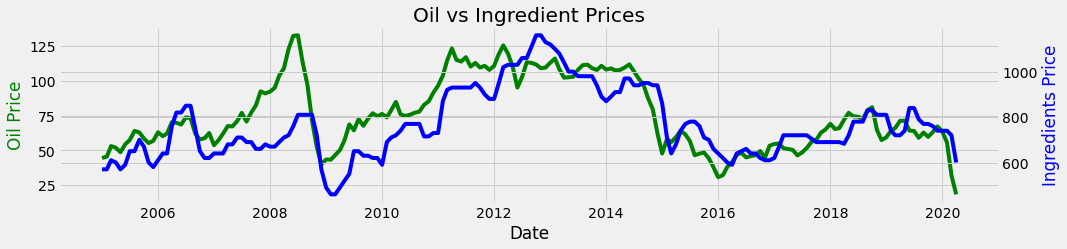

In [12]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df.index, df['Price_oil'], 'g-', )
ax2.plot(df.index, df['Price_ingredients'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Price', color='g')
ax2.set_ylabel('Ingredients Price', color='b')

plt.title('Oil vs Ingredient Prices')
plt.show()

**Covariance**
<br> Covariance can be defined as a measure of how much two random variables vary together.' and in the above visuals, there is most definitely a following, for the most part it appears that ingredients seems to be following crude oil prices with a short lag(delay). 

Let us investage the relationship.

Definitions:
<br>
<br> **Trend**: The increasing or decreasing value in the series.
<br> **Seasonality**: The data follows a repetitive/cyclical pattern.
<br> **Residual**: The random variation in the series.

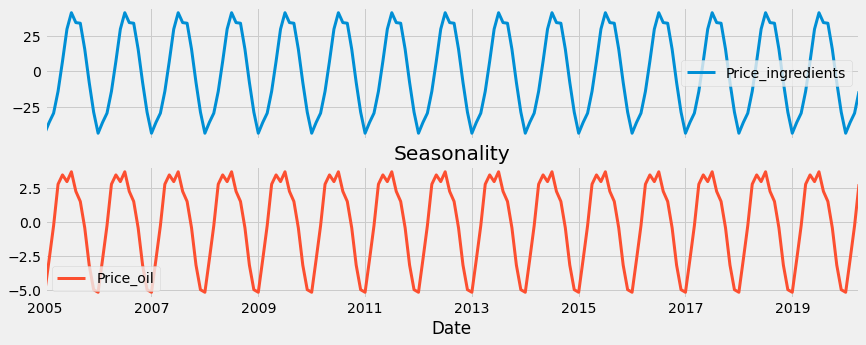

In [13]:
# visualize seasonality
seasonality_dict = {}

for price in df.columns:
    decompositions = sm.tsa.seasonal_decompose(df[price] , model='additive')
    # Store the results back
    seasonality_dict[price] = decompositions.seasonal
    

# Plot
plt.rcParams['figure.figsize'] = 13, 5
pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(2, 1), linewidth=3,);
plt.title('Seasonality')
plt.show()

From the above it appears there is consistent patterns of twin peaks in the middle of each year for both oil and price. The first being oil price.

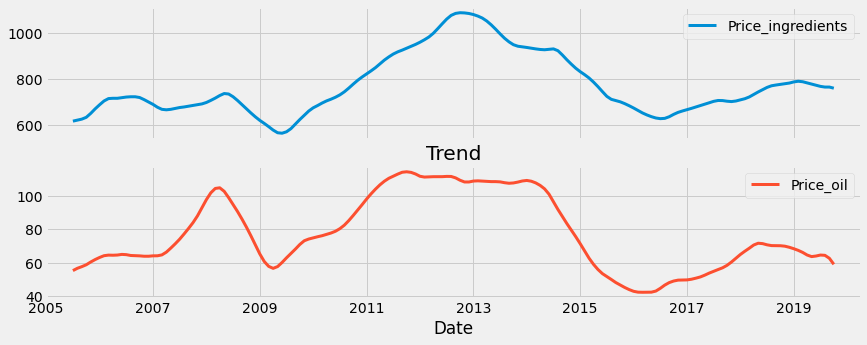

In [14]:
# visualize trend
trend_dict = {}

for price in df.columns:
    decompositions = sm.tsa.seasonal_decompose(df[price] , model='additive')
    # Store the results back
    trend_dict[price] = decompositions.trend
    

# Plot
plt.rcParams['figure.figsize'] = 13, 5
pd.DataFrame(trend_dict).plot(
    subplots=True, layout=(2, 1), linewidth=3)
plt.title('Trend')
plt.show()

In the above there does not appear any trends, be it linear or quandratic, however both prices trend is very similar.

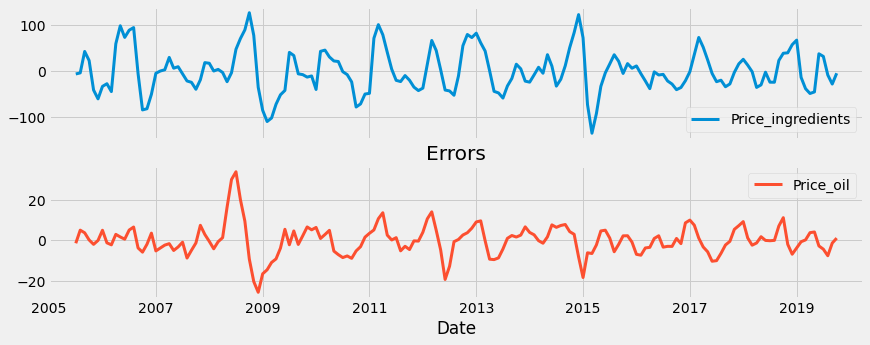

In [15]:
# visualize resid
resid_dict = {}

for price in df.columns:
    decompositions = sm.tsa.seasonal_decompose(df[price] , model='additive')
    # Store the results back
    resid_dict[price] = decompositions.resid
    

# Plot
plt.rcParams['figure.figsize'] = 13, 5
pd.DataFrame(resid_dict).plot(
    subplots=True, layout=(2, 1), linewidth=3)
plt.title('Errors')
plt.show()

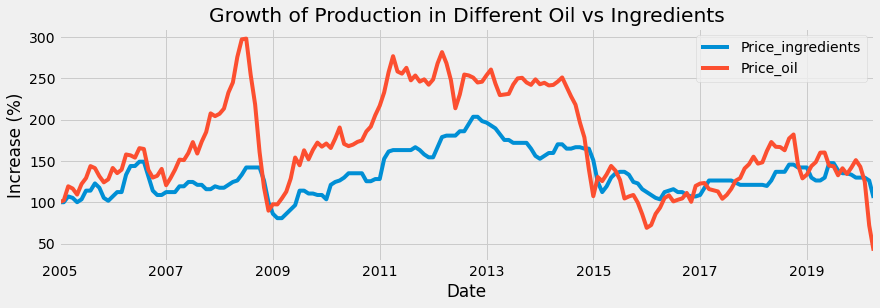

In [16]:
#percentage change in price
normalized = df.div(df.iloc[0]).mul(100)  # Multiply by 100 to get percentages

normalized.plot(figsize=(13, 4), title='Growth of Production in Different Oil vs Ingredients')
plt.xlabel('Date')
plt.ylabel('Increase (%)');

**Autocorrelation:**

Autocorrelation measures the degree of similarity between a time series and a lagged version of itself over successive time intervals. This is useful because it informs us on the quantity of lags to consider for prediction.

ACF explains how the present value of a given time series is correlated with the past (1-unit past, 2-unit past, …, n-unit past) values. In the ACF plot, the x-axis expresses the correlation coefficient whereas the y-axis mentions the number of lags. Assume that, y(t-1)

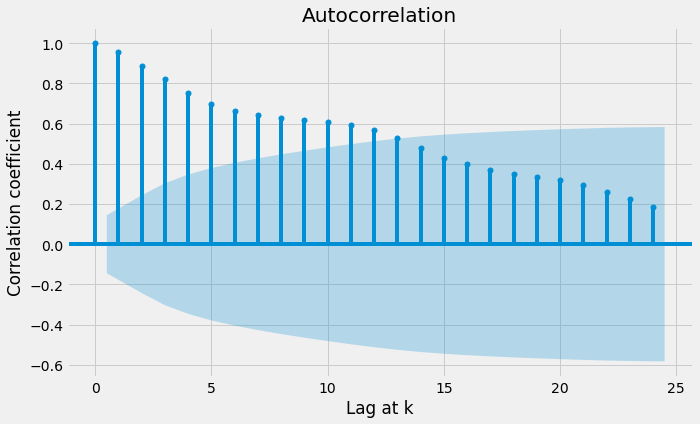

In [17]:
#Evaluate MA with ACF
from statsmodels.graphics import tsaplots

plt.rcParams['figure.figsize'] = 10, 6

# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(df['Price_ingredients'], lags=24)

plt.xlabel('Lag at k')
plt.ylabel('Correlation coefficient')
plt.show()

**Ingredient Price Autocorrelation:**

The results of autocorrelation on ingredient price indicates that strong similarity between prices recent prices and older prices, however the further one dives back to older data, the lesser the similarity in the period of 24 months. This indicates that one may use a time series model of previous ingredients prices to predict future prices. The shaded area displays confidence level declining the further the difference grows, the further one goes back in time. Here the most correlated lags are 1.

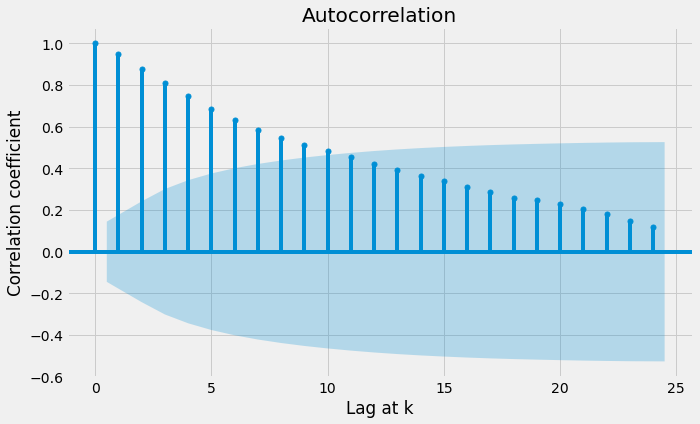

In [18]:
plt.rcParams['figure.figsize'] = 10, 6

# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(df['Price_oil'], lags=24)

plt.xlabel('Lag at k')
plt.ylabel('Correlation coefficient')
plt.show()

**Oil Price Autocorrelation:**

Similarly to ingredients, the is positive correlation between oil prices and its older prices. The same approach can be taken herein. It would appear that most correlated lags are 1.

PACF is the partial autocorrelation function that explains the partial correlation between the series and lags of itself. In simple terms, PACF can be explained using a linear regression where we predict y(t) from y(t-1), y(t-2), and y(t-3)

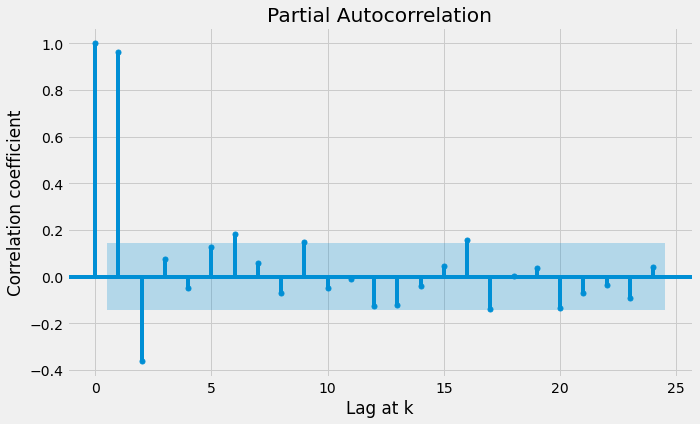

In [19]:
# PACF evaluate autoregressive part of P (p,d,q) for ingredient
fig = tsaplots.plot_pacf(df['Price_ingredients'], lags=24)

plt.xlabel('Lag at k')
plt.ylabel('Correlation coefficient')
plt.show()

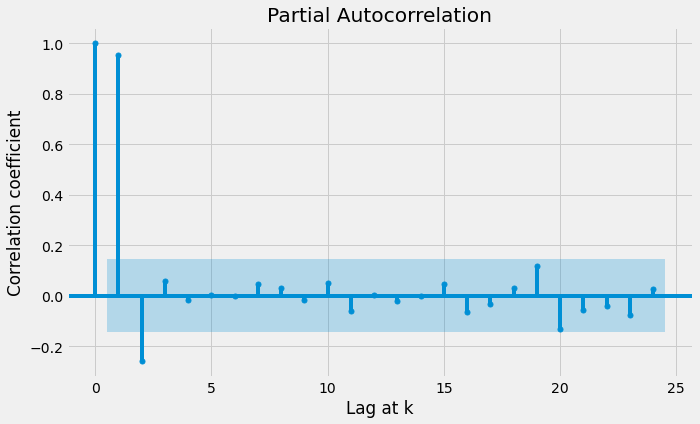

In [20]:
# PACF evaluate autoregressive part of P (p,d,q) for oil
fig = tsaplots.plot_pacf(df['Price_oil'], lags=24)

plt.xlabel('Lag at k')
plt.ylabel('Correlation coefficient')
plt.show()

Similary to the Autocorrelation curves, the cut off point here is 1 lag

**Cross correlation:**

Cross correlation is a way to measure the degree of similarity between a time series and a lagged version of another time series.

This type of correlation is useful to calculate because it can tell us if the values of one time series are predictive of the future values of another time series. 

Pandas computed Pearson r: 0.7523641248757335
Scipy computed Pearson r: 0.7523641248757331 and p-value: 7.942162571462919e-35


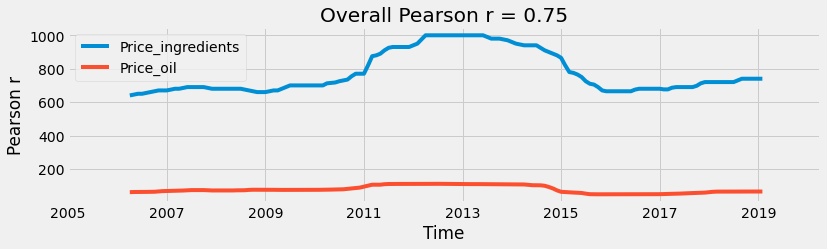

In [21]:
import scipy.stats as stats

overall_pearson_r = df.corr().iloc[0,1]
print(f'Pandas computed Pearson r: {overall_pearson_r}')
r, p = stats.pearsonr(df.dropna()['Price_oil'], df.dropna()['Price_ingredients'])
print(f'Scipy computed Pearson r: {r} and p-value: {p}')

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(12,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f'Overall Pearson r = {np.round(overall_pearson_r,2)}')

Time Lagged Cross Correlation — assessing signal dynamics
Time lagged cross correlation (TLCC) can identify directionality between two signals such as a leader-follower relationship in which the leader initiates a response which is repeated by the follower. There are couple ways to do investigate such relationship including Granger causality.

TLCC is measured by incrementally shifting one time series vector (red) and repeatedly calculating the correlation between two signals. If the peak correlation is at the center (offset=0), this indicates the two time series are most synchronized at that time. However, the peak correlation may be at a different offset if one signal leads another. The code below implements a cross correlation function using pandas functionality. It can also wrap the data so that the correlation values on the edges are still calculated by adding the data from the other side of the signal.

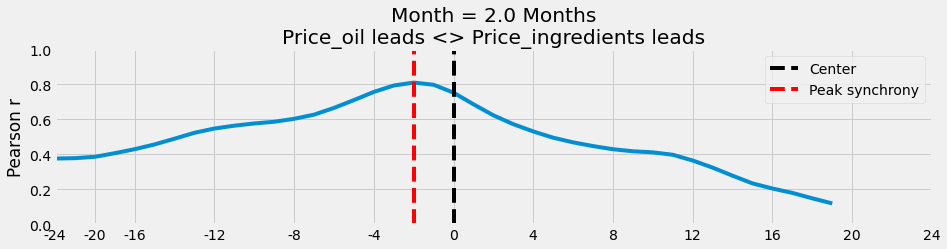

In [22]:
def crosscorr(datax, datay, lag=0, wrap=False):
    ''' Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    '''
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['Price_oil']
d2 = df['Price_ingredients']

rs = [crosscorr(d1,d2, lag) for lag in range(-int(20),int(20))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Month = {offset} Months\nPrice_oil leads <> Price_ingredients leads',ylim=[0,1],xlim=[0,24],ylabel='Pearson r')
ax.set_xticks([0, 2, 4,8,12,16,20,24, 28, 32, 36, 40, 44])
ax.set_xticklabels([-24,-20,-16,-12, -8, -4, 0, 4, 8, 12, 16, 20, 24]);
plt.legend()
plt.show()

In the plot above, we can infer from the negative offset that oil price is leading the interaction (correlation is maximized when ingredients is brought forward by 2 months. In simple terms this means that oil price on average an oil price is most correlated with ingredient price 2 months later. e.g. If oil price increases by x% in January 2020, ingredient prices that are most correlated to x% will most likely occur in March 2020.

In [23]:
#As discussed above, create a new feature from lagging leading oil price by 2 months
df['price_oil_lagged'] = df['Price_oil'].shift(2)
df.dropna(inplace=True)

<a id='model_development'></a>
**Prediction:**

Let us create a baseline predictor in order to predict ingredient prices. This will be done by creating a lag.

In [24]:
# Lagging the time series by 1, provide view just using past month as a predictor
df_base = pd.concat([df['Price_ingredients'], df['Price_ingredients'].shift(1)], axis=1)
df_base.columns = ['actual_price', 'forecast_ingr_price']
df_base.dropna(inplace=True)

from sklearn.metrics import mean_squared_error

# Use mean squared error to evaluate accuracy 
mse = ((df_base['actual_price']['2017':] - df_base['forecast_ingr_price']['2017':]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)), '. Let us proceed with alternative model')

The Mean Squared Error of our forecasts is 1185.31
The Root Mean Squared Error of our forecasts is 34.43 . Let us proceed with alternative model


#### Summary

Thus far we are able to conclude the following:
<br>
1. We have statistically proved that neither oil or ingredient prices are stationary. Meaning that it is not stable and flunctuates over time. 
2. That both prices are exposed to seasonality, whereby there is consistant patterns that happen during particular periods each year.
3. The trends for these prices are not constant, as they peaked around 2011 - 2014 and have both declined since.
4. Both prices are highly correlated with their own past prices and can be used to predict its future prices in the short term.
5. Oil and ingredients prices are approximately 75% positively correlated - meaning the prices change are closely similar.
6. Lastly, we are able to prove that oil price changes are most related to changes in ingredients 2 months after.

The above conclusions/assumptions leads us to attempt to predict future ingredient prices using an apporach that is best suited for the conditions. One such model is SARIMAX.

****SAMRIMAX:****
Seasonal Autoregressive Integrated Moving Average Exogenous.
In short this model is able to predict dependent variables such as ingredient, in a space where there is perceived seasonality, trend, none stationary variables and aditional variables that is highly correlated with ingredient price such as crude oil prices. 

For more detail behind the maths of SARIMAX: https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html


#### Model Development

In order for SARIMAX to produce optimal results, it needs to identify the following:
<br>
<br>p = the order of the (AR) term
<br>d is the number of differencing(I) required to make the time series stationary
<br>q is the order of the (MA) term

However, one of the benefit of SARIMAX is that it can correct for seasonality.

In [25]:
# Hyperparameter tuning to find best combination of orders to pass in the sarimax mode

import itertools

#using pcf & acf conclusions to create ranges 0 - 1
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [26]:
#Hyperparameter tuning for SARIMAX using above mentioned opions. Select lowest AIC for particular run
# AIC - The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data.

d = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['Price_ingredients'],
                                            exog=df['price_oil_lagged'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            d.append({ 'Param': param,'Param_season': param_seasonal,'AIC': results.aic})
            options = pd.DataFrame(d)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2333.3568323725667
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2171.9985322432617
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2010.9464524301545
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1852.9116521280403
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2023.918038098725
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1993.671190695256
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1868.142463406171
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1859.193702145934
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2141.5667791444207
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1993.655647297617
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1832.3290863464688
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1688.7793971866424
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1858.6209010433633
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1828.6456169182793
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1714.5494854794251
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1694.760015138844
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1799.8405751629448
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1653.314145603020

In [27]:
#create object for best performing hyperparameters to capture lowest AIC scre from above
low_param = options[options.AIC == options.AIC.min()]['Param'].iloc[0]
low_param_season = options[options.AIC == options.AIC.min()]['Param_season'].iloc[0]

#Build SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df['Price_ingredients'],
                                exog=df['price_oil_lagged'],
                                order=low_param,
                                seasonal_order=low_param_season,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

#View model results
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  Price_ingredients   No. Observations:                  182
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -760.766
Date:                            Mon, 28 Mar 2022   AIC                           1531.532
Time:                                    11:40:45   BIC                           1546.749
Sample:                                03-01-2005   HQIC                          1537.712
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
price_oil_lagged     2.4193      0.319      7.573      0.000       1.793       3.045
ar.L1            

If the p-value is less than 0.05, we reject the null hypothesis that there's no difference between the means and conclude that a significant difference does exist. If the p-value is larger than 0.05, we cannot conclude that a significant difference exists.

With that said, the above results suggest that per unit increase in price of oil, on average, ingredient price increases by 2.5.

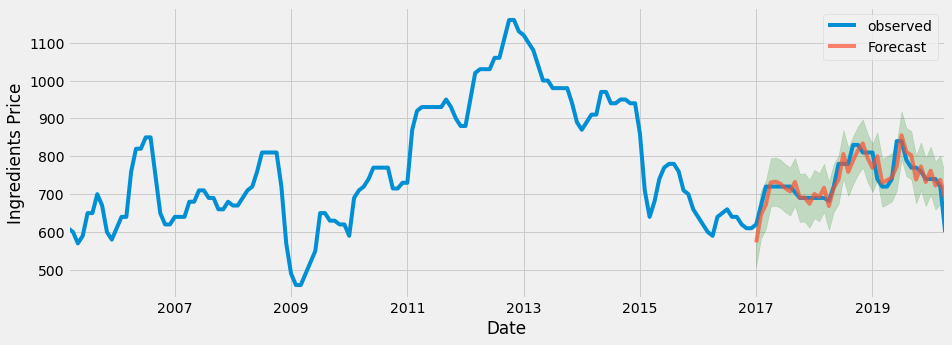

In [28]:
#create a predictor from 
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False, exog=df['price_oil_lagged'], )
pred_ci = pred.conf_int()
ax = df['Price_ingredients']['2005':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Ingredients Price')
plt.legend()
plt.show()

In [29]:
#evaluate the accuracy of the model since 2017 - 2020
y_forecasted = pred.predicted_mean
y_truth = df['Price_ingredients']['2017':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)), 'which is better than baseline model, not bad but could be better.' )

The Mean Squared Error of our forecasts is 868.96
The Root Mean Squared Error of our forecasts is 29.48 which is better than baseline model, not bad but could be better.


<a id='Recommendation'></a>
**Recommendation:**
1. IFF can use can use oil prices changes as an indicator of changes in ingredient price
2. We can use SARIMAX to forecast ingredient prices two months ahead.
3. A unit increase in oil prices is doubled in ingredient prices 2 months after, which can be assist in pricing for goods and procurement demand planning.
4. Although oil price has strong correlation with ingredients it may not be the only variable that affects ingredient prices. Things to consider may be macro &micro economical variables such as other related products, and social/political climates that may shock the prices e.g. Russia/Ukrain war etc... these may be additional expgenous variables to model.

Citings:

Cheong, J. H. (2020, December 8). Four ways to quantify synchrony between time series data. https://doi.org/10.17605/OSF.IO/BA3NY

Li, Susan (2018, July 19). An End-to-End Project on Time Series Analysis and Forecasting with Python
https://medium.com/towards-data-science/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

Duke University Introduction to ARIMA: nonseasonal models
https://people.duke.edu/~rnau/411arim.htm